<a href="https://colab.research.google.com/github/beomm2/AI_lab_seongbeom/blob/main/week3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [32]:
!pip install boto3

In [33]:
from google.colab import drive
drive.mount('/content/drive')

import torch
import torchaudio
import torchaudio.functional as F
import torchaudio.transforms as T
import io
import os
import tarfile
import tempfile

import boto3
import matplotlib.pyplot as plt
import requests
from botocore import UNSIGNED
from botocore.config import Config
from IPython.display import Audio
from torchaudio.utils import download_asset

waveform1, sample_rate1 = torchaudio.load("/content/drive/MyDrive/Colab Notebooks/2025-2-AI/audio_dataset/095522039.m4a")
waveform2, sample_rate2 = torchaudio.load("/content/drive/MyDrive/Colab Notebooks/2025-2-AI/audio_dataset/095522040.m4a")
waveform3, sample_rate3 = torchaudio.load("/content/drive/MyDrive/Colab Notebooks/2025-2-AI/audio_dataset/095522041.m4a")
waveform4, sample_rate4 = torchaudio.load("/content/drive/MyDrive/Colab Notebooks/2025-2-AI/audio_dataset/095522042.m4a")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


/usr/local/lib/python3.12/dist-packages/torchaudio/_backend/utils.py:213: UserWarning: In 2.9, this function's implementation will be changed to use torchaudio.load_with_torchcodec` under the hood. Some parameters like ``normalize``, ``format``, ``buffer_size``, and ``backend`` will be ignored. We recommend that you port your code to rely directly on TorchCodec's decoder instead: https://docs.pytorch.org/torchcodec/stable/generated/torchcodec.decoders.AudioDecoder.html#torchcodec.decoders.AudioDecoder.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchaudio/_backend/ffmpeg.py:88: UserWarning: torio.io._streaming_media_decoder.StreamingMediaDecoder has been deprecated. This deprecation is part of a large refactoring effort to transition TorchAudio into a maintenance phase. The decoding and encoding capabilities of PyTorch for both audio and video are being consolidated into TorchCodec. Please see https://github.com/pytorch/audio/issues/3902 for more information. It will be r

In [34]:
def plot_waveform(waveform, sample_rate):
    waveform = waveform.numpy()

    num_channels, num_frames = waveform.shape
    time_axis = torch.arange(0, num_frames) / sample_rate

    figure, axes = plt.subplots(num_channels, 1)
    if num_channels == 1:
        axes = [axes]
    for c in range(num_channels):
        axes[c].plot(time_axis, waveform[c], linewidth=1)
        axes[c].grid(True)
        if num_channels > 1:
            axes[c].set_ylabel(f"Channel {c+1}")
    figure.suptitle("waveform")

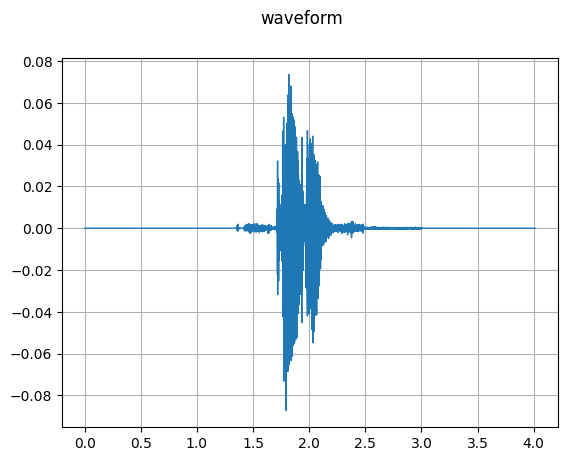

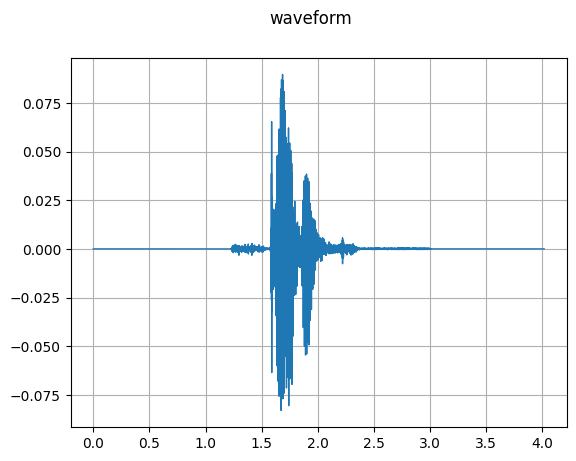

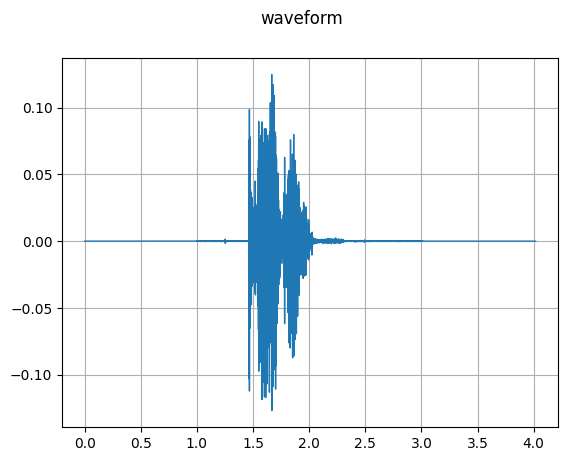

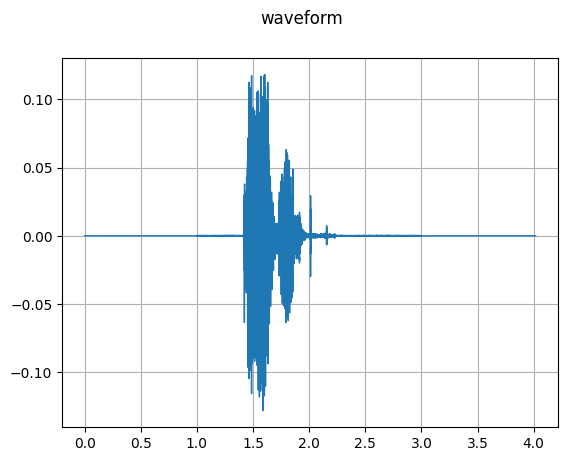

In [35]:
plot_waveform(waveform1, sample_rate1)
plot_waveform(waveform2, sample_rate2)
plot_waveform(waveform3, sample_rate3)
plot_waveform(waveform4, sample_rate4)

In [36]:
def plot_specgram(waveform, sample_rate, title="Spectrogram"):
  waveform = waveform.numpy()

  num_channels, num_frames = waveform.shape

  figure, axes = plt.subplots(num_channels, 1)
  if num_channels == 1:
    axes = [axes]
  for c in range(num_channels):
    axes[c].specgram(waveform[c], Fs=sample_rate)
    if num_channels > 1:
      axes[c].set_ylabel(f"Channel {c+1}")
    figure.suptitle(title)


/usr/local/lib/python3.12/dist-packages/matplotlib/axes/_axes.py:8233: RuntimeWarning: divide by zero encountered in log10
  Z = 10. * np.log10(spec)


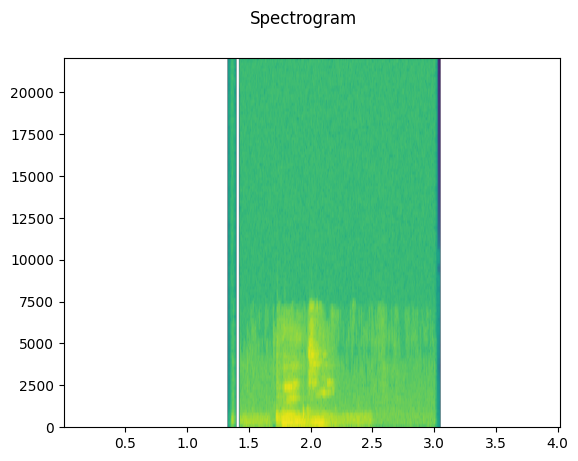

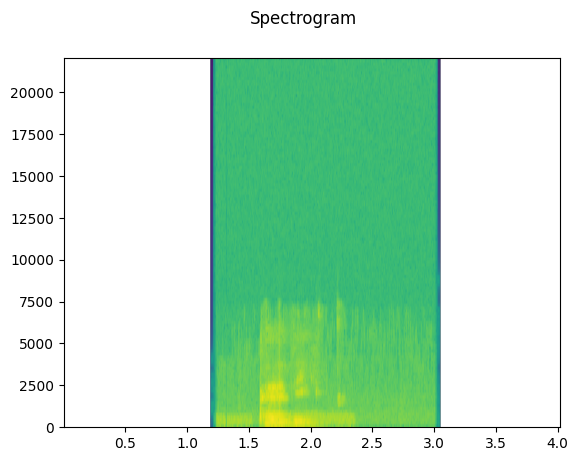

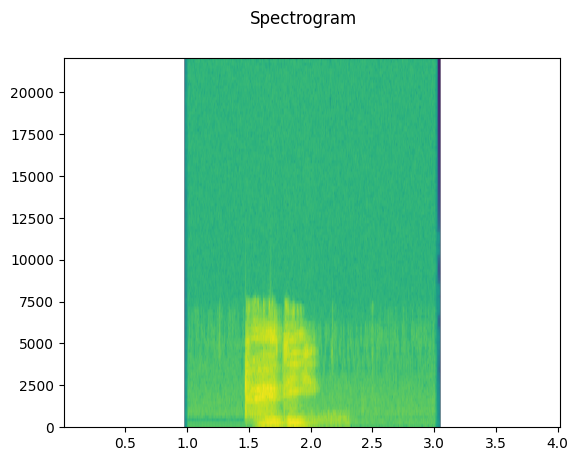

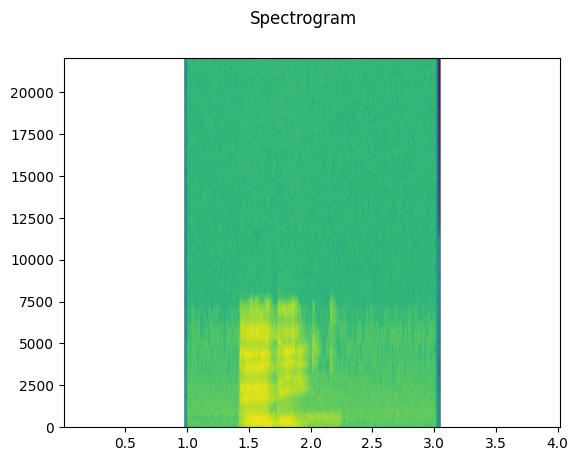

In [37]:
plot_specgram(waveform1, sample_rate1)
plot_specgram(waveform2, sample_rate2)
plot_specgram(waveform3, sample_rate3)
plot_specgram(waveform4, sample_rate4)

In [38]:
import math
import timeit

import librosa
import matplotlib.colors as mcolors
import matplotlib.pyplot as plt
import pandas as pd
import resampy
from IPython.display import Audio

pd.set_option("display.max_rows", None)
pd.set_option("display.max_columns", None)

DEFAULT_OFFSET = 201


def _get_log_freq(sample_rate, max_sweep_rate, offset):
    """Get freqs evenly spaced out in log-scale, between [0, max_sweep_rate // 2]

    offset is used to avoid negative infinity `log(offset + x)`.

    """
    start, stop = math.log(offset), math.log(offset + max_sweep_rate // 2)
    return torch.exp(torch.linspace(start, stop, sample_rate, dtype=torch.double)) - offset


def _get_inverse_log_freq(freq, sample_rate, offset):
    """Find the time where the given frequency is given by _get_log_freq"""
    half = sample_rate // 2
    return sample_rate * (math.log(1 + freq / offset) / math.log(1 + half / offset))


def _get_freq_ticks(sample_rate, offset, f_max):
    # Given the original sample rate used for generating the sweep,
    # find the x-axis value where the log-scale major frequency values fall in
    times, freq = [], []
    for exp in range(2, 5):
        for v in range(1, 10):
            f = v * 10**exp
            if f < sample_rate // 2:
                t = _get_inverse_log_freq(f, sample_rate, offset) / sample_rate
                times.append(t)
                freq.append(f)
    t_max = _get_inverse_log_freq(f_max, sample_rate, offset) / sample_rate
    times.append(t_max)
    freq.append(f_max)
    return times, freq


def get_sine_sweep(sample_rate, offset=DEFAULT_OFFSET):
    max_sweep_rate = sample_rate
    freq = _get_log_freq(sample_rate, max_sweep_rate, offset)
    delta = 2 * math.pi * freq / sample_rate
    cummulative = torch.cumsum(delta, dim=0)
    signal = torch.sin(cummulative).unsqueeze(dim=0)
    return signal


def plot_sweep(
    waveform,
    sample_rate,
    title,
    max_sweep_rate=48000,
    offset=DEFAULT_OFFSET,
):
    x_ticks = [100, 500, 1000, 5000, 10000, 20000, max_sweep_rate // 2]
    y_ticks = [1000, 5000, 10000, 20000, sample_rate // 2]

    time, freq = _get_freq_ticks(max_sweep_rate, offset, sample_rate // 2)
    freq_x = [f if f in x_ticks and f <= max_sweep_rate // 2 else None for f in freq]
    freq_y = [f for f in freq if f in y_ticks and 1000 <= f <= sample_rate // 2]

    figure, axis = plt.subplots(1, 1)
    _, _, _, cax = axis.specgram(waveform[0].numpy(), Fs=sample_rate)
    plt.xticks(time, freq_x)
    plt.yticks(freq_y, freq_y)
    axis.set_xlabel("Original Signal Frequency (Hz, log scale)")
    axis.set_ylabel("Waveform Frequency (Hz)")
    axis.xaxis.grid(True, alpha=0.67)
    axis.yaxis.grid(True, alpha=0.67)
    figure.suptitle(f"{title} (sample rate: {sample_rate} Hz)")
    plt.colorbar(cax)

In [39]:
!pip install resampy

In [40]:
def benchmark_resample_functional(
    waveform,
    sample_rate,
    resample_rate,
    lowpass_filter_width=6,
    rolloff=0.99,
    resampling_method="sinc_interp_hann",
    beta=None,
    iters=5,
):
    return (
        timeit.timeit(
            stmt="""
torchaudio.functional.resample(
    waveform,
    sample_rate,
    resample_rate,
    lowpass_filter_width=lowpass_filter_width,
    rolloff=rolloff,
    resampling_method=resampling_method,
    beta=beta,
)
        """,
            setup="import torchaudio",
            number=iters,
            globals=locals(),
        )
        * 1000
        / iters
    )

In [41]:
def benchmark_resample_transforms(
    waveform,
    sample_rate,
    resample_rate,
    lowpass_filter_width=6,
    rolloff=0.99,
    resampling_method="sinc_interp_hann",
    beta=None,
    iters=5,
):
    return (
        timeit.timeit(
            stmt="resampler(waveform)",
            setup="""
import torchaudio

resampler = torchaudio.transforms.Resample(
    sample_rate,
    resample_rate,
    lowpass_filter_width=lowpass_filter_width,
    rolloff=rolloff,
    resampling_method=resampling_method,
    dtype=waveform.dtype,
    beta=beta,
)
resampler.to(waveform.device)
        """,
            number=iters,
            globals=locals(),
        )
        * 1000
        / iters
    )

In [42]:
def benchmark_resample_librosa(
    waveform,
    sample_rate,
    resample_rate,
    res_type=None,
    iters=5,
):
    waveform_np = waveform.squeeze().numpy()
    return (
        timeit.timeit(
            stmt="""
librosa.resample(
    waveform_np,
    orig_sr=sample_rate,
    target_sr=resample_rate,
    res_type=res_type,
)
        """,
            setup="import librosa",
            number=iters,
            globals=locals(),
        )
        * 1000
        / iters
    )

In [43]:
def benchmark(sample_rate, resample_rate):
    times, rows = [], []
    waveform = get_sine_sweep(sample_rate).to(torch.float32)

    args = (waveform, sample_rate, resample_rate)

    # sinc 64 zero-crossings
    f_time = benchmark_resample_functional(*args, lowpass_filter_width=64)
    t_time = benchmark_resample_transforms(*args, lowpass_filter_width=64)
    times.append([None, f_time, t_time])
    rows.append("sinc (width 64)")

    # sinc 6 zero-crossings
    f_time = benchmark_resample_functional(*args, lowpass_filter_width=16)
    t_time = benchmark_resample_transforms(*args, lowpass_filter_width=16)
    times.append([None, f_time, t_time])
    rows.append("sinc (width 16)")

    # kaiser best
    kwargs = {
        "lowpass_filter_width": 64,
        "rolloff": 0.9475937167399596,
        "resampling_method": "sinc_interp_kaiser",
        "beta": 14.769656459379492,
    }
    lib_time = benchmark_resample_librosa(*args, res_type="kaiser_best")
    f_time = benchmark_resample_functional(*args, **kwargs)
    t_time = benchmark_resample_transforms(*args, **kwargs)
    times.append([lib_time, f_time, t_time])
    rows.append("kaiser_best")

    # kaiser fast
    kwargs = {
        "lowpass_filter_width": 16,
        "rolloff": 0.85,
        "resampling_method": "sinc_interp_kaiser",
        "beta": 8.555504641634386,
    }
    lib_time = benchmark_resample_librosa(*args, res_type="kaiser_fast")
    f_time = benchmark_resample_functional(*args, **kwargs)
    t_time = benchmark_resample_transforms(*args, **kwargs)
    times.append([lib_time, f_time, t_time])
    rows.append("kaiser_fast")

    df = pd.DataFrame(times, columns=["librosa", "functional", "transforms"], index=rows)
    return df

In [44]:
def plot(df):
    print(df.round(2))
    ax = df.plot(kind="bar")
    plt.ylabel("Time Elapsed [ms]")
    plt.xticks(rotation=0, fontsize=10)
    for cont, col, color in zip(ax.containers, df.columns, mcolors.TABLEAU_COLORS):
        label = ["N/A" if v != v else str(v) for v in df[col].round(2)]
        ax.bar_label(cont, labels=label, color=color, fontweight="bold", fontsize="x-small")

                 librosa  functional  transforms
sinc (width 64)      NaN       10.38        8.42
sinc (width 16)      NaN        3.22        2.69
kaiser_best         44.6       16.07        8.49
kaiser_fast         20.3        8.55        3.89
                 librosa  functional  transforms
sinc (width 64)      NaN       11.05       15.54
sinc (width 16)      NaN        5.66        5.09
kaiser_best        48.73        9.28       11.19
kaiser_fast        30.43        6.27        7.22
                 librosa  functional  transforms
sinc (width 64)      NaN        5.52        5.00
sinc (width 16)      NaN        1.95        1.70
kaiser_best        33.32        9.56       10.80
kaiser_fast        21.74        3.70        3.31
                 librosa  functional  transforms
sinc (width 64)      NaN        5.45        5.01
sinc (width 16)      NaN        1.91        1.59
kaiser_best        34.69        5.77        5.30
kaiser_fast        12.56        3.17        2.19


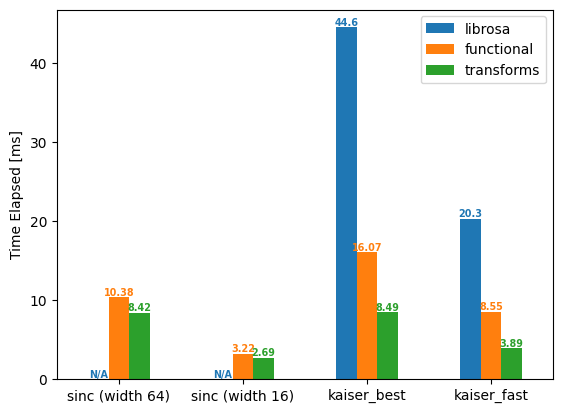

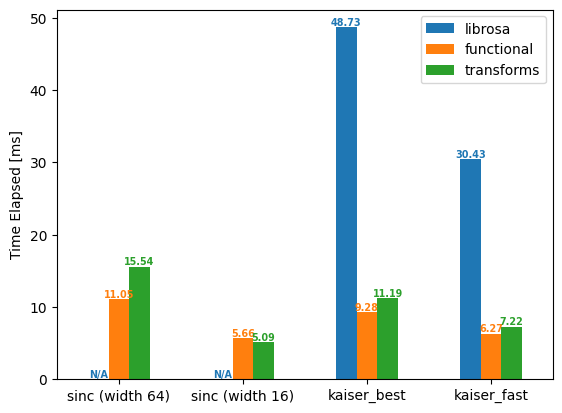

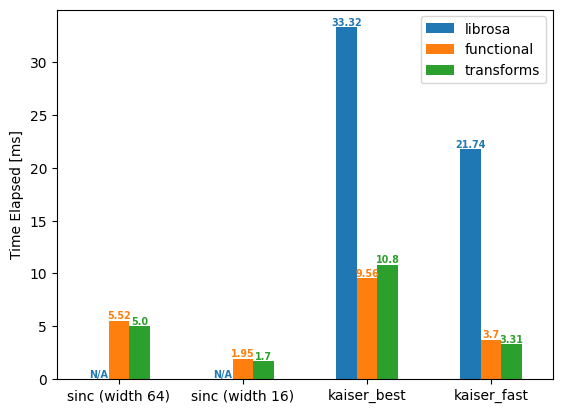

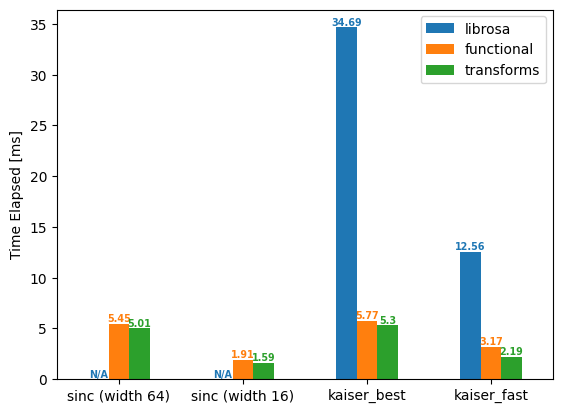

In [46]:
df = benchmark(sample_rate1, sample_rate1 // 2)
plot(df)

df = benchmark(sample_rate2, sample_rate2 // 2)
plot(df)

df = benchmark(sample_rate3, sample_rate3 // 2)
plot(df)

df = benchmark(sample_rate4, sample_rate4 // 2)
plot(df)

                 librosa  functional  transforms
sinc (width 64)      NaN        7.39        5.43
sinc (width 16)      NaN        2.94        1.91
kaiser_best        51.10        6.05        5.43
kaiser_fast        24.29        2.90        2.20
                 librosa  functional  transforms
sinc (width 64)      NaN        6.06        6.15
sinc (width 16)      NaN        3.47        3.09
kaiser_best        50.65        5.96        5.38
kaiser_fast        24.37        2.53        2.11
                 librosa  functional  transforms
sinc (width 64)      NaN        5.67        5.30
sinc (width 16)      NaN        2.23        1.84
kaiser_best        50.89        5.86        5.36
kaiser_fast        25.33        4.05        2.39
                 librosa  functional  transforms
sinc (width 64)      NaN        5.44        5.18
sinc (width 16)      NaN        2.12        1.79
kaiser_best        50.29        6.10        5.40
kaiser_fast        24.23        2.52        2.06


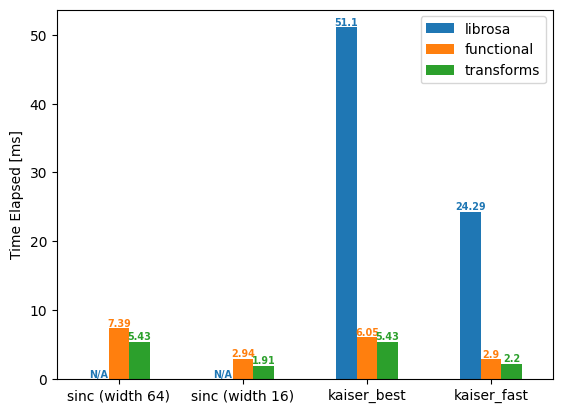

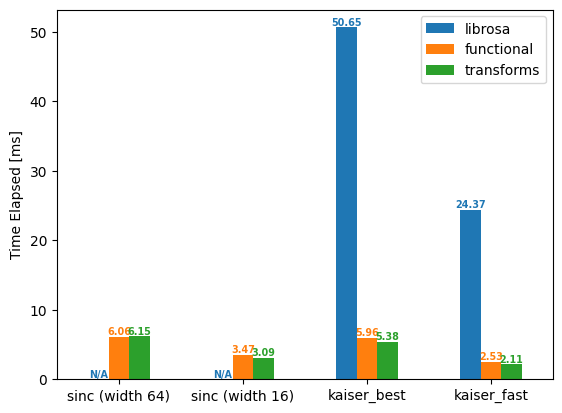

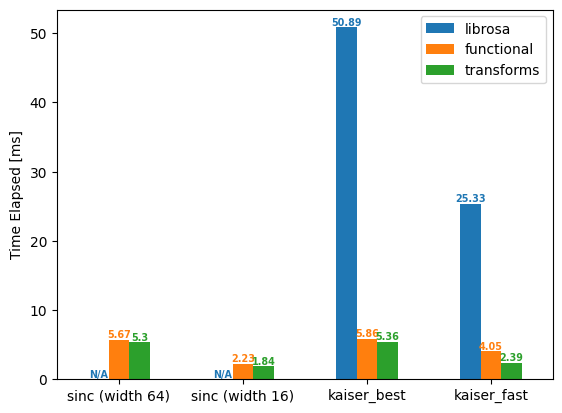

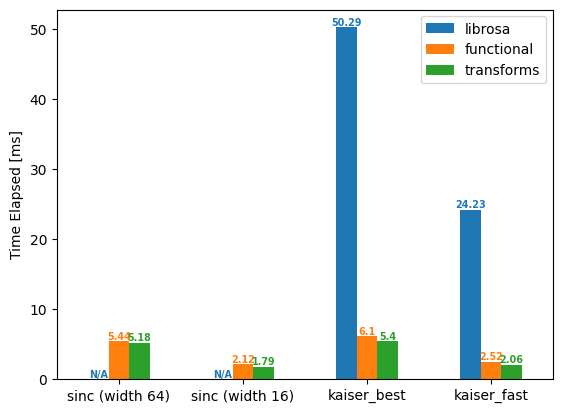

In [47]:
df = benchmark(sample_rate1, sample_rate1 * 2)
plot(df)

df = benchmark(sample_rate2, sample_rate2 * 2)
plot(df)

df = benchmark(sample_rate3, sample_rate3 * 2)
plot(df)

df = benchmark(sample_rate4, sample_rate4 * 2)
plot(df)